# Sentiment Analysis of Code-Switching Hindi and Marathi in Roman Script

The implementation includes:
1. Setup and Imports
2. Data preprocessing and exploration
3. Text Preprocessing (Roman Script)
4. Transliteration from Roman to Devanagari
5. Preprocessing for Devanagari Text
6. MuRIL model Baseline Accuracy
7. Hyperparameter Tuning for Best Parameters
8. Fine-Tunning Cross Validation for MuRIL
9. Baseline Implementations for MuRIL, IndicBERTv1, XLM-RoBERTa, mBERT
10. Hyperparameter Tuning for All Models using Optuna
11. Model Testing: Intra-sentential vs Inter-sentential vs Tag-Switch (Testing Separately)
12. Cross-Script Evaluation: Train on Roman, Test on Devanagari
13. Cross-Script Evaluation: Train on Devnagri, Test on Roman




## 1. Setup and Imports

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.8 MB/s eta 0:00:00


In [2]:
# Install required packages
!pip install indic-transliteration


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 4.1 MB/s eta 0:00:00


In [3]:
#Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import optuna
import warnings
import os
import random
import time
import gc
warnings.filterwarnings("ignore")

#Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed_value)

set_seed(42)

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Using device: cuda
GPU: Tesla T4


## 2. Data Loading and Exploration

Dataset shape: (299, 2)

First few rows:


,text,sentiment
0,"Tera idea ekdam mast hota, tyamule project kha...",Positive
1,"Ya movie chi katha zabardast ahe, mujhe roj ya...",Positive
2,"Tujhi smile baghun mala khush vatla, tension g...",Positive
3,"Kalachya party madhe sab khush hote, tujhya en...",Positive
4,Tujhya support shivay mazya kamyabi la shakya ...,Positive



Missing values:
text         0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
Negative    150
Positive    149
Name: count, dtype: int64


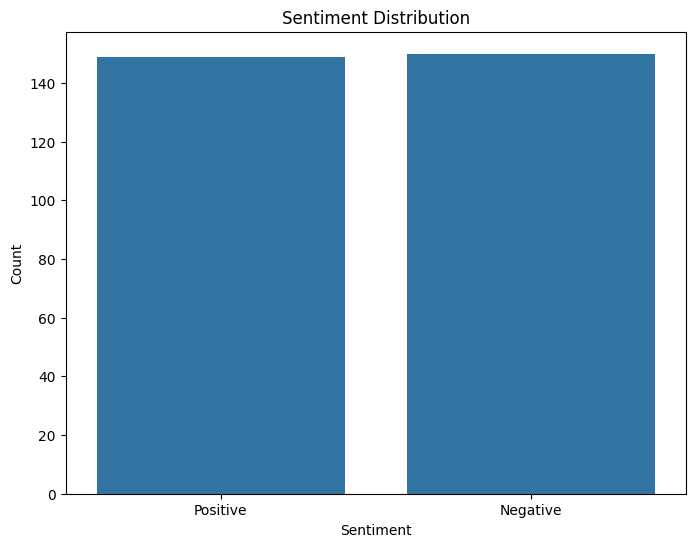


Text length statistics:
count    299.000000
mean      47.100334
std       14.855568
min       13.000000
25%       35.000000
50%       49.000000
75%       57.000000
max       83.000000
Name: text_length, dtype: float64


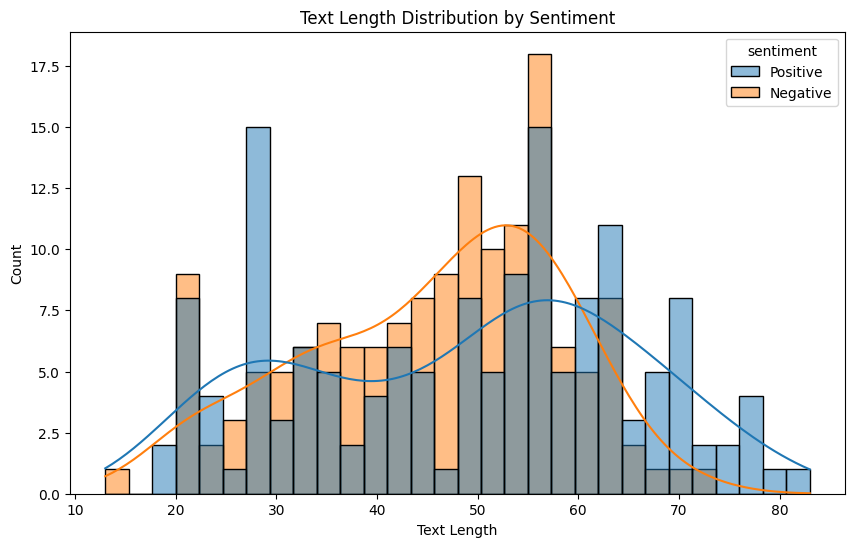

In [4]:
# Load the dataset
df = pd.read_csv("Dataset.csv")
df.columns = ["text", "sentiment"]

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Distribution of sentiment classes
print("\nSentiment distribution:")
sentiment_counts = df["sentiment"].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Text length statistics
df["text_length"] = df["text"].apply(len)
print("\nText length statistics:")
print(df["text_length"].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="text_length", hue="sentiment", bins=30, kde=True)
plt.title("Text Length Distribution by Sentiment")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

## 3. Text Preprocessing (Roman Script)

In [5]:
def preprocess_text(text):
    """
    Preprocess text for Roman script Hindi-Marathi code-switched text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)

    # Remove punctuation except those that might be important for sentiment
    text = re.sub(r"[^\w\s!?.]", "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply preprocessing
df["cleaned_text"] = df["text"].apply(preprocess_text)

# Display examples of cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(5):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")
    print("-" * 50)

Original vs Cleaned Text Examples:
Original: Tera idea ekdam mast hota, tyamule project khatam jhala
Cleaned: tera idea ekdam mast hota tyamule project khatam jhala
--------------------------------------------------
Original: Ya movie chi katha zabardast ahe, mujhe roj yaad aayegi
Cleaned: ya movie chi katha zabardast ahe mujhe roj yaad aayegi
--------------------------------------------------
Original: Tujhi smile baghun mala khush vatla, tension gela dur
Cleaned: tujhi smile baghun mala khush vatla tension gela dur
--------------------------------------------------
Original: Kalachya party madhe sab khush hote, tujhya energy ne sabko achha laga
Cleaned: kalachya party madhe sab khush hote tujhya energy ne sabko achha laga
--------------------------------------------------
Original: Tujhya support shivay mazya kamyabi la shakya navhati
Cleaned: tujhya support shivay mazya kamyabi la shakya navhati
--------------------------------------------------


## 4. Transliteration from Roman to Devanagari



In [6]:
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def transliterate_roman_to_devanagari(text):
    """
    Transliterate Roman script to Devanagari script with enhanced accuracy
    for Hindi/Marathi code-switched text
    """
    try:
        # Pre-processing to improve transliteration accuracy
        text = re.sub(r"([.,!?])", r"\1 ", text)
        text = re.sub(r"\s+", " ", text).strip()

        # Common word mappings for better accuracy
        word_mappings = {
            # Hindi common words
            "hai": "है", "hota": "होता", "mujhe": "मुझे", "tumhara": "तुम्हारा",
            "tumhari": "तुम्हारी", "tera": "तेरा", "mera": "मेरा", "achha": "अच्छा",
            "acha": "अच्छा", "bahut": "बहुत", "khush": "खुश", "nahin": "नहीं",
            "nahi": "नहीं", "aur": "और", "par": "पर", "mein": "में",
            "kya": "क्या", "ko": "को", "se": "से", "ke": "के",
            "ki": "की", "ka": "का", "sab": "सब", "sabko": "सबको",
            "khatam": "खतम", "yaad": "याद", "roj": "रोज", "idea": "आइडिया",
            "project": "प्रोजेक्ट", "movie": "मूवी", "smile": "स्माइल", "tension": "टेंशन",
            "party": "पार्टी", "energy": "एनर्जी", "support": "सपोर्ट", "weather": "वेदर",
            "walk": "वॉक", "enjoy": "एन्जॉय", "gift": "गिफ्ट", "surprise": "सरप्राइज",
            "effort": "एफर्ट",

            # Marathi common words
            "ahe": "आहे", "hota": "होता", "mala": "मला", "tula": "तुला",
            "tumcha": "तुमचा", "tumchi": "तुमची", "tujha": "तुझा", "tujhi": "तुझी",
            "tujhya": "तुझ्या", "majha": "माझा", "mazya": "माझ्या", "chan": "छान",
            "khup": "खूप", "nahi": "नाही", "ani": "आणि", "pan": "पण",
            "madhe": "मध्ये", "var": "वर", "khar": "खर", "la": "ला",
            "chi": "ची", "cha": "चा", "che": "चे", "katha": "कथा",
            "baghun": "बघून", "vatla": "वाटलं", "gela": "गेला", "dur": "दूर",
            "kalachya": "कालच्या", "shakya": "शक्य", "navhati": "नव्हती", "aajchya": "आजच्या",
            "maja": "मजा", "thandak": "थंडक", "keli": "केली", "asanyane": "असण्याने",
            "sukun": "सुखून", "khana": "खाना", "chav": "चव", "unique": "युनिक",
            "kela": "केला", "avdela": "आवडला", "anand": "आनंद", "zala": "झाला",
            "jagi": "जगी", "konalach": "कोणालाच",

            # Common expressions
            "namaste": "नमस्ते", "namaskar": "नमस्कार", "dhanyavad": "धन्यवाद", "shukriya": "शुक्रिया",
            "kaise": "कैसे", "kasa": "कसा", "kashi": "कशी", "ekdam": "एकदम",
            "zabardast": "जबरदस्त", "mast": "मस्त", "tyamule": "त्यामुळे", "jhala": "झाला",
            "aayegi": "आएगी", "shivay": "शिवाय", "kamyabi": "कामयाबी", "karne": "करने",
            "ala": "आला", "dekh": "देख", "chinta": "चिंता", "geli": "गेली",
            "mom": "मॉम", "khas": "खास", "banavla": "बनवला", "dekhake": "देखके",
            "tumchy": "तुमच्या",
        }

        # Split text into words for word-by-word processing
        words = text.split()
        processed_words = []

        for word in words:
            # Check if word is in our mapping dictionary
            word_lower = word.lower()
            if word_lower in word_mappings:
                processed_words.append(word_mappings[word_lower])
            else:
                # Try to transliterate using the library
                try:
                    # Convert to ITRANS format first (an intermediate step)
                    # This helps with better recognition of Hindi/Marathi phonetics
                    itrans_word = word
                    # Apply transliteration
                    dev_word = transliterate(itrans_word, sanscript.ITRANS, sanscript.DEVANAGARI)
                    processed_words.append(dev_word)
                except Exception as e:
                    # If transliteration fails, keep the original word
                    processed_words.append(word)

        # Join the processed words back into text
        result = " ".join(processed_words)

        # Post-processing for better readability
        # Fix common transliteration issues
        result = result.replace(".", "|")

        return result
    except Exception as e:
        print(f"Error in transliteration: {e}")
        return text  # Return original text if transliteration fails

# Apply transliteration to the dataset
df["devanagari_text"] = df["cleaned_text"].apply(transliterate_roman_to_devanagari)

# Display examples of transliterated text
print("Roman vs Devanagari Text Examples:")
for i in range(5):
    print(f"Roman: {df['cleaned_text'].iloc[i]}")
    print(f"Devanagari: {df['devanagari_text'].iloc[i]}")
    print("-" * 50)

Roman vs Devanagari Text Examples:
Roman: tera idea ekdam mast hota tyamule project khatam jhala
Devanagari: तेरा आइडिया एकदम मस्त होता त्यामुळे प्रोजेक्ट खतम झाला
--------------------------------------------------
Roman: ya movie chi katha zabardast ahe mujhe roj yaad aayegi
Devanagari: य मूवी ची कथा जबरदस्त आहे मुझे रोज याद आएगी
--------------------------------------------------
Roman: tujhi smile baghun mala khush vatla tension gela dur
Devanagari: तुझी स्माइल बघून मला खुश वाटलं टेंशन गेला दूर
--------------------------------------------------
Roman: kalachya party madhe sab khush hote tujhya energy ne sabko achha laga
Devanagari: कालच्या पार्टी मध्ये सब खुश होते तुझ्या एनर्जी ने सबको अच्छा लग
--------------------------------------------------
Roman: tujhya support shivay mazya kamyabi la shakya navhati
Devanagari: तुझ्या सपोर्ट शिवाय माझ्या कामयाबी ला शक्य नव्हती
--------------------------------------------------


## 5. Preprocessing for Devanagari Text

In [7]:
# Define Hindi and Marathi stopwords in Devanagari
hindi_stopwords = [
    "और", "का", "की", "के", "को", "में", "से", "पर", "है", "हैं", "था", "थे", "थी", "थीं",
    "हो", "होता", "होती", "होते", "हुआ", "हुई", "हुए", "एक", "यह", "वह", "ये", "वे", "जो",
    "कि", "तो", "अगर", "या", "एवं", "तथा", "कर", "करे", "करें", "कहते", "कहा", "गया", "अब",
    "जब", "तब", "कब", "यदि", "यहाँ", "वहाँ", "कहाँ", "क्यों", "क्योंकि", "परंतु", "लेकिन",
    "अपना", "अपनी", "अपने", "स्वयं", "इस", "उस", "इन", "उन", "सकता", "सकते", "सकती",
    "रहा", "रहे", "रही", "रखें", "रखे", "रखता", "रखती", "रखते", "बहुत", "थोड़ा", "थोड़े",
    "थोड़ी", "साथ", "बाद", "पहले", "फिर", "वापस", "द्वारा", "प्रति", "अंदर", "बाहर", "आज",
    "कल", "अभी", "जल्दी", "शीघ्र", "धीरे", "अधिक", "कम", "ज्यादा", "सभी", "कुछ", "कौन",
    "क्या", "कैसे", "कहां", "किसे", "किसका", "किसकी", "किसके", "किस", "किसी", "कोई",
    "हूँ", "हूं", "हो", "हम", "तुम", "आप", "वो", "मैं", "मुझे", "मेरा", "मेरी", "मेरे",
    "तेरा", "तेरी", "तेरे", "उसका", "उसकी", "उसके", "हमारा", "हमारी", "हमारे", "आपका",
    "आपकी", "आपके", "उनका", "उनकी", "उनके", "इसका", "इसकी", "इसके", "उसको", "इसको"
]

marathi_stopwords = [
    "आणि", "आहे", "आहेत", "होते", "होता", "होती", "होत्या", "असून", "असे", "असा", "अशी",
    "असलेल्या", "असलेला", "असलेली", "असतो", "असते", "असतात", "म्हणून", "परंतु", "पण",
    "तर", "मात्र", "की", "कारण", "म्हणजे", "हे", "ही", "हा", "ते", "ती", "तो", "त्या",
    "त्याचा", "त्याची", "त्याचे", "त्यांचा", "त्यांची", "त्यांचे", "त्यांना", "त्याला",
    "त्याने", "त्यांनी", "त्यामुळे", "या", "याचा", "याची", "याचे", "यांचा", "यांची",
    "यांचे", "यांना", "याला", "याने", "यांनी", "यामुळे", "जे", "जो", "जी", "ज्या",
    "ज्याचा", "ज्याची", "ज्याचे", "ज्यांचा", "ज्यांची", "ज्यांचे", "ज्यांना", "ज्याला",
    "ज्याने", "ज्यांनी", "ज्यामुळे", "मी", "माझा", "माझी", "माझे", "मला", "आम्ही",
    "आमचा", "आमची", "आमचे", "आम्हाला", "आपण", "आपला", "आपली", "आपले", "आपल्याला",
    "तू", "तुझा", "तुझी", "तुझे", "तुला", "तुम्ही", "तुमचा", "तुमची", "तुमचे", "तुम्हाला",
    "एक", "दोन", "तीन", "चार", "पाच", "सहा", "सात", "आठ", "नऊ", "दहा", "वर", "वरती",
    "खाली", "येथे", "तेथे", "कधी", "कसे", "का", "काय", "कोण", "कोणता", "कोणती", "कोणते",
    "कोणाचा", "कोणाची", "कोणाचे", "कोणाला", "कोणी", "कोणास", "काही", "कुठे", "कुठल्या",
    "कुठला", "कुठली", "कुठले", "कसा", "कशी", "कशाला", "कशामुळे", "कशासाठी", "कशात",
    "इतर", "इतका", "इतकी", "इतके", "इकडे", "तिकडे", "मध्ये", "मधील", "वरील", "खालील",
    "पुढील", "मागील", "आतील", "बाहेरील", "अंतर्गत", "बाहेर", "आत", "पुढे", "मागे", "वरून",
    "खालून", "पर्यंत", "पासून", "साठी", "करिता", "द्वारे", "विषयी", "बद्दल", "शिवाय",
    "प्रमाणे", "नुसार", "ऐवजी", "सोबत", "बरोबर", "विना", "नंतर", "पूर्वी", "आधी", "दरम्यान"
]

# Combine Hindi and Marathi stopwords
indic_stopwords = set(hindi_stopwords + marathi_stopwords)

def preprocess_devanagari_text(text):
    """
    Preprocess Devanagari text for Hindi-Marathi code-switched text
    """
    # Tokenize text (simple space-based tokenization for Devanagari)
    tokens = text.split()

    # Remove stopwords
    tokens = [token for token in tokens if token not in indic_stopwords]

    # Join tokens back into text
    processed_text = " ".join(tokens)

    return processed_text

# Apply Devanagari preprocessing
df["processed_devanagari"] = df["devanagari_text"].apply(preprocess_devanagari_text)

# Display examples of processed Devanagari text
print("Original vs Processed Devanagari Text Examples:")
for i in range(5):
    print(f"Original Devanagari: {df['devanagari_text'].iloc[i]}")
    print(f"Processed Devanagari: {df['processed_devanagari'].iloc[i]}")
    print("-" * 50)

Original vs Processed Devanagari Text Examples:
Original Devanagari: तेरा आइडिया एकदम मस्त होता त्यामुळे प्रोजेक्ट खतम झाला
Processed Devanagari: आइडिया एकदम मस्त प्रोजेक्ट खतम झाला
--------------------------------------------------
Original Devanagari: य मूवी ची कथा जबरदस्त आहे मुझे रोज याद आएगी
Processed Devanagari: य मूवी ची कथा जबरदस्त रोज याद आएगी
--------------------------------------------------
Original Devanagari: तुझी स्माइल बघून मला खुश वाटलं टेंशन गेला दूर
Processed Devanagari: स्माइल बघून खुश वाटलं टेंशन गेला दूर
--------------------------------------------------
Original Devanagari: कालच्या पार्टी मध्ये सब खुश होते तुझ्या एनर्जी ने सबको अच्छा लग
Processed Devanagari: कालच्या पार्टी सब खुश तुझ्या एनर्जी ने सबको अच्छा लग
--------------------------------------------------
Original Devanagari: तुझ्या सपोर्ट शिवाय माझ्या कामयाबी ला शक्य नव्हती
Processed Devanagari: तुझ्या सपोर्ट माझ्या कामयाबी ला शक्य नव्हती
--------------------------------------------------


In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["label"] = torch.tensor(label)
        return item


#6.MuRIL model Baseline Accuracy

In [9]:
# Evaluate base MuRIL model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader

# Prepare features and labels from original dataframe
X_all = df["devanagari_text"]
y_all = df["sentiment"].map({"Positive": 1, "Negative": 0})



# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)
model.to(device)
model.eval()

# Prepare dataset and dataloader
base_dataset = SentimentDataset(X_all, y_all, tokenizer)
base_loader = DataLoader(base_dataset, batch_size=8)

# Evaluation
correct, total = 0, 0
with torch.no_grad():
    for batch in base_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

base_accuracy = correct / total
print(f"\nAccuracy of base MuRIL model (without fine-tuning): {base_accuracy:.4f}")


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Accuracy of base MuRIL model (without fine-tuning): 0.4983


# 7. Hyperparameter Tuning for Best Parameters






In [10]:


# Stratified Split for Tuning
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
    epochs = trial.suggest_int("epochs", 3, 15)
    freeze_layers = trial.suggest_categorical("freeze_layers", [True, False])
    freeze_embeddings = trial.suggest_categorical("freeze_embeddings", [True, False])

    tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

    if freeze_embeddings:
        for param in model.bert.embeddings.parameters():
            param.requires_grad = False
    if freeze_layers:
        for param in model.bert.encoder.parameters():
            param.requires_grad = False

    model.to(device)
    train_dataset = SentimentDataset(X_train_tf, y_train_tf, tokenizer)
    val_dataset = SentimentDataset(X_val_tf, y_val_tf, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * epochs)

    for _ in range(epochs):
        model.train()
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            loss = model(**inputs, labels=labels).loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    torch.cuda.empty_cache()
    gc.collect()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-08-18 12:46:27,853] A new study created in memory with name: no-name-5c764510-7225-4aec-9ad3-9471d924834e
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 12:47:26,945] Trial 0 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 4.230335025919623e-05, 'batch_size': 4, 'epochs': 5, 'freeze_layers': False, 'freeze_embeddings': False}. Best is trial 0 with value: 0.7666666666666667.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 12:49:52,7

Best Hyperparameters: {'learning_rate': 1.1847749611735298e-05, 'batch_size': 4, 'epochs': 14, 'freeze_layers': False, 'freeze_embeddings': False}


# 8. Fine-Tunning Cross Validation

In [11]:


def lightweight_finetune_transformer(
    model_name,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs,
    batch_size,
    learning_rate,
    freeze_layers,
    freeze_embeddings,
):
    print(f"\nLightweight fine-tuning of {model_name} with best hyperparameters...")
    print(f"  Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {learning_rate:.2e}")
    print(f"  Freeze transformer layers: {freeze_layers}, Freeze embeddings: {freeze_embeddings}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    if freeze_embeddings:
      print("  Freezing embedding layers...")

      if hasattr(model, 'bert'):
          for param in model.bert.embeddings.parameters():
              param.requires_grad = False
      elif hasattr(model, 'roberta'):
          for param in model.roberta.embeddings.parameters():
              param.requires_grad = False
      elif hasattr(model, 'xlm_roberta'):
          for param in model.xlm_roberta.embeddings.parameters():
              param.requires_grad = False
      elif hasattr(model, 'albert'):
          for param in model.albert.embeddings.parameters():
              param.requires_grad = False
      else:
          print("  [Warning] Could not freeze embeddings: Unknown model structure.")

    if freeze_layers:
      print("  Freezing transformer encoder layers...")

      if hasattr(model, 'bert'):
          for param in model.bert.encoder.parameters():
              param.requires_grad = False
      elif hasattr(model, 'roberta'):
          for param in model.roberta.encoder.parameters():
              param.requires_grad = False
      elif hasattr(model, 'albert'):
          for param in model.albert.encoder.parameters():
              param.requires_grad = False
      elif hasattr(model, 'base_model') and hasattr(model.base_model, 'encoder'):
          for param in model.base_model.encoder.parameters():
              param.requires_grad = False
      else:
          print("  [Warning] Could not freeze encoder layers: Unknown model structure.")


    model.to(device)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

    train_dataset = SentimentDataset(X_train, y_train, tokenizer)
    test_dataset = SentimentDataset(X_test, y_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * epochs)

    best_accuracy = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        start_time = time.time()
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)
        train_time = time.time() - start_time

        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Training Time: {train_time:.2f} seconds")

        # Evaluation phase
        model.eval()
        total_test_loss, correct_test, total_test = 0, 0, 0
        all_preds, all_labels = [], []
        start_time = time.time()
        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(device)

                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                total_test_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_acc = correct_test / total_test
        avg_test_loss = total_test_loss / len(test_loader)
        test_time = time.time() - start_time

        print(f"  Test Loss: {avg_test_loss:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Test Time: {test_time:.2f} seconds")

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            print(f"  New best model saved with test accuracy: {test_acc:.4f}")

    # Final report
    print(f"\n{model_name} Final Test Accuracy: {best_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

    output_dir = model_name.replace("/", "_") + "_model_final"
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Final model saved to {output_dir}")

    return {"accuracy": best_accuracy}



In [12]:
from sklearn.model_selection import StratifiedKFold

X_all = df["devanagari_text"].reset_index(drop=True)
y_all = df["sentiment"].map({"Positive": 1, "Negative": 0}).reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cv_results = []

for train_index, test_index in skf.split(X_all, y_all):
    print(f"\nFold {fold}")

    X_train_fold = X_all.iloc[train_index].reset_index(drop=True)
    X_test_fold = X_all.iloc[test_index].reset_index(drop=True)
    y_train_fold = y_all.iloc[train_index].reset_index(drop=True)
    y_test_fold = y_all.iloc[test_index].reset_index(drop=True)

    result = lightweight_finetune_transformer(
        model_name="google/muril-base-cased",
        X_train=X_train_fold,
        y_train=y_train_fold,
        X_test=X_test_fold,
        y_test=y_test_fold,
        epochs=best_params["epochs"],  #using tuned value
        batch_size=best_params["batch_size"],
        learning_rate=best_params["learning_rate"],
        freeze_layers=best_params["freeze_layers"],
        freeze_embeddings=best_params["freeze_embeddings"]
    )

    cv_results.append(result['accuracy'])
    print(f" Fold {fold} Accuracy: {result['accuracy']:.4f}")
    fold += 1

mean_acc = np.mean(cv_results)
std_acc = np.std(cv_results)
print(f"\nFinal Cross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



Fold 1

Lightweight fine-tuning of google/muril-base-cased with best hyperparameters...
  Epochs: 14, Batch size: 4, Learning rate: 1.18e-05
  Freeze transformer layers: False, Freeze embeddings: False


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/14
  Training Loss: 0.6932
  Training Accuracy: 0.4728
  Training Time: 10.22 seconds
  Test Loss: 0.6927
  Test Accuracy: 0.5000
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6883
  Training Accuracy: 0.7071
  Training Time: 10.18 seconds
  Test Loss: 0.6811
  Test Accuracy: 0.6833
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.6833

Epoch 3/14
  Training Loss: 0.6366
  Training Accuracy: 0.8410
  Training Time: 10.19 seconds
  Test Loss: 0.6264
  Test Accuracy: 0.7333
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7333

Epoch 4/14
  Training Loss: 0.5505
  Training Accuracy: 0.9289
  Training Time: 10.20 seconds
  Test Loss: 0.5838
  Test Accuracy: 0.7667
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.7667

Epoch 5/14
  Training Loss: 0.4736
  Training Accuracy: 0.9582
  Training Time:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/14
  Training Loss: 0.6933
  Training Accuracy: 0.4937
  Training Time: 10.21 seconds
  Test Loss: 0.6931
  Test Accuracy: 0.5000
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6920
  Training Accuracy: 0.5649
  Training Time: 10.26 seconds
  Test Loss: 0.6892
  Test Accuracy: 0.6333
  Test Time: 0.47 seconds
  New best model saved with test accuracy: 0.6333

Epoch 3/14
  Training Loss: 0.6529
  Training Accuracy: 0.8368
  Training Time: 10.31 seconds
  Test Loss: 0.6220
  Test Accuracy: 0.7833
  Test Time: 0.46 seconds
  New best model saved with test accuracy: 0.7833

Epoch 4/14
  Training Loss: 0.5530
  Training Accuracy: 0.9414
  Training Time: 10.24 seconds
  Test Loss: 0.5510
  Test Accuracy: 0.8667
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.8667

Epoch 5/14
  Training Loss: 0.4701
  Training Accuracy: 0.9623
  Training Time:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/14
  Training Loss: 0.6934
  Training Accuracy: 0.4979
  Training Time: 10.23 seconds
  Test Loss: 0.6929
  Test Accuracy: 0.5000
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6908
  Training Accuracy: 0.6402
  Training Time: 10.25 seconds
  Test Loss: 0.6831
  Test Accuracy: 0.8333
  Test Time: 0.46 seconds
  New best model saved with test accuracy: 0.8333

Epoch 3/14
  Training Loss: 0.6579
  Training Accuracy: 0.8075
  Training Time: 10.31 seconds
  Test Loss: 0.6209
  Test Accuracy: 0.8333
  Test Time: 0.47 seconds

Epoch 4/14
  Training Loss: 0.5715
  Training Accuracy: 0.9163
  Training Time: 10.22 seconds
  Test Loss: 0.5604
  Test Accuracy: 0.8500
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.8500

Epoch 5/14
  Training Loss: 0.4850
  Training Accuracy: 0.9582
  Training Time: 10.17 seconds
  Test Loss: 0.4870
  Test Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/14
  Training Loss: 0.6932
  Training Accuracy: 0.4812
  Training Time: 10.18 seconds
  Test Loss: 0.6929
  Test Accuracy: 0.5000
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6917
  Training Accuracy: 0.5439
  Training Time: 10.22 seconds
  Test Loss: 0.6861
  Test Accuracy: 0.5500
  Test Time: 0.46 seconds
  New best model saved with test accuracy: 0.5500

Epoch 3/14
  Training Loss: 0.6697
  Training Accuracy: 0.7364
  Training Time: 10.29 seconds
  Test Loss: 0.6612
  Test Accuracy: 0.7167
  Test Time: 0.47 seconds
  New best model saved with test accuracy: 0.7167

Epoch 4/14
  Training Loss: 0.5979
  Training Accuracy: 0.8870
  Training Time: 10.28 seconds
  Test Loss: 0.5668
  Test Accuracy: 0.8667
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.8667

Epoch 5/14
  Training Loss: 0.4990
  Training Accuracy: 0.9623
  Training Time:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/14
  Training Loss: 0.6933
  Training Accuracy: 0.4958
  Training Time: 10.20 seconds
  Test Loss: 0.6920
  Test Accuracy: 0.5085
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.5085

Epoch 2/14
  Training Loss: 0.6865
  Training Accuracy: 0.5292
  Training Time: 10.24 seconds
  Test Loss: 0.6737
  Test Accuracy: 0.6949
  Test Time: 0.46 seconds
  New best model saved with test accuracy: 0.6949

Epoch 3/14
  Training Loss: 0.6640
  Training Accuracy: 0.7542
  Training Time: 10.33 seconds
  Test Loss: 0.6493
  Test Accuracy: 0.7797
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.7797

Epoch 4/14
  Training Loss: 0.5921
  Training Accuracy: 0.9125
  Training Time: 10.30 seconds
  Test Loss: 0.5881
  Test Accuracy: 0.7966
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7966

Epoch 5/14
  Training Loss: 0.5045
  Training Accuracy: 0.9333
  Training Time:

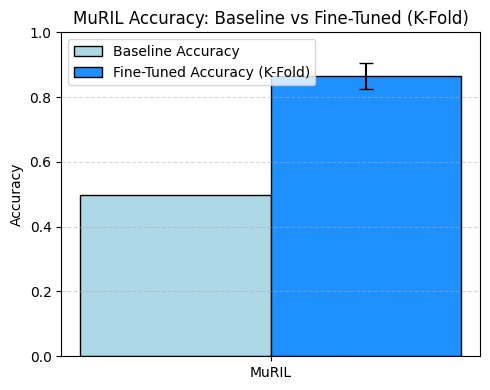

In [13]:
import matplotlib.pyplot as plt

# Accuracy values
muril_baseline = base_accuracy
muril_kfold = mean_acc
muril_kfold_std = std_acc

# Create the figure
plt.figure(figsize=(5, 4))
bar_width = 0.08  # Thin bars

# Plot bars with black border
plt.bar(0 - bar_width/2, muril_baseline, width=bar_width, color='lightblue',
        edgecolor='black', label='Baseline Accuracy')

# Fine-tuned with standard deviation as error bar
plt.bar(0 + bar_width/2, muril_kfold, width=bar_width, color='dodgerblue',
        edgecolor='black', yerr=muril_kfold_std, capsize=5, label='Fine-Tuned Accuracy (K-Fold)')

# Set chart details
plt.xticks([0], ["MuRIL"])
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("MuRIL Accuracy: Baseline vs Fine-Tuned (K-Fold)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 9. Baseline Implementations for MuRIL, IndicBERTv1, XLM-RoBERTa, mBERT

In [14]:


# Label mapping and preparation
label_map = {"Positive": 1, "Negative": 0}
df["labels"] = df["sentiment"].map(label_map)



BATCH_SIZE = 16

# Models to evaluate
MODELS = {
    "MuRIL": "google/muril-base-cased",
    "IndicBERTv1": "ai4bharat/indic-bert",
    "XLM-RoBERTa": "xlm-roberta-base",
    "mBERT": "bert-base-multilingual-cased",
}

# Placeholder for results
baseline_results = {}

print("--- Baseline Implementations ---")
for model_name, model_path in MODELS.items():
    print(f"\n--- Running Baseline for {model_name} ---")

    # Split the data
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["labels"])
    df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train["labels"])

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(label_map))
    model.to(device)
    model.eval()

    # Create datasets and dataloaders
    train_dataset = SentimentDataset(df_train["devanagari_text"], df_train["labels"], tokenizer)
    val_dataset = SentimentDataset(df_val["devanagari_text"], df_val["labels"], tokenizer)
    test_dataset = SentimentDataset(df_test["devanagari_text"], df_test["labels"], tokenizer)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Evaluate without fine-tuning (like your MuRIL code)
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    baseline_results[model_name] = test_accuracy
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")

    del model
    torch.cuda.empty_cache()
    gc.collect()

# Summary
print("\n--- Baseline Results ---")
for model, accuracy in baseline_results.items():
    print(f"{model}: {accuracy:.4f}")


--- Baseline Implementations ---

--- Running Baseline for MuRIL ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MuRIL Test Accuracy: 0.5000

--- Running Baseline for IndicBERTv1 ---


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IndicBERTv1 Test Accuracy: 0.4833

--- Running Baseline for XLM-RoBERTa ---


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLM-RoBERTa Test Accuracy: 0.5000

--- Running Baseline for mBERT ---


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mBERT Test Accuracy: 0.4833

--- Baseline Results ---
MuRIL: 0.5000
IndicBERTv1: 0.4833
XLM-RoBERTa: 0.5000
mBERT: 0.4833


## 10. Hyperparameter Tuning for All Models using Optuna

In [15]:
best_hyperparameters = {}
print("--- Running Hyperparameter Tuning ---")

for model_name, model_path in MODELS.items():
    print(f"\n--- Running Hyperparameter Tuning for {model_name} ---")

    def objective(trial):
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
        epochs = trial.suggest_int("epochs", 3, 15)
        freeze_layers = trial.suggest_categorical("freeze_layers", [True, False])
        freeze_embeddings = trial.suggest_categorical("freeze_embeddings", [True, False])

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["labels"])
        df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train["labels"])

        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(label_map))


        base_model = model.base_model

        if freeze_embeddings:
            for param in base_model.embeddings.parameters():
                param.requires_grad = False
        if freeze_layers:
            for param in base_model.encoder.parameters():
                param.requires_grad = False

        model.to(device)

        train_dataset = SentimentDataset(df_train["devanagari_text"], df_train["labels"], tokenizer)
        val_dataset = SentimentDataset(df_val["devanagari_text"], df_val["labels"], tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * epochs)

        # Training loop
        for _ in range(epochs):
            model.train()
            for batch in train_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(device)

                optimizer.zero_grad()
                loss = model(**inputs, labels=labels).loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

        # Validation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(device)
                outputs = model(**inputs)
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        torch.cuda.empty_cache()
        gc.collect()

        return correct / total

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=8)

    print(f"\nBest trial for {model_name}:")
    print(f"  Value: {study.best_trial.value:.4f}")
    print(f"  Params: {study.best_trial.params}")
    best_hyperparameters[model_name] = study.best_trial.params

print("\n--- Best Hyperparameters for Each Model ---")
for model, params in best_hyperparameters.items():
    print(f"{model}: {params}")


[I 2025-08-18 13:11:44,227] A new study created in memory with name: no-name-f264b507-2e72-4336-882d-2f1c9615da35


--- Running Hyperparameter Tuning ---

--- Running Hyperparameter Tuning for MuRIL ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:12:06,949] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 4.200885206255045e-05, 'batch_size': 16, 'epochs': 12, 'freeze_layers': True, 'freeze_embeddings': True}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:12:58,465] Trial 1 finished with value: 0.7916666666666666 and parameters: {'learning_rate': 1.824073538598386e-05, 'batch_size': 16, 'epochs': 9, 'fre


Best trial for MuRIL:
  Value: 0.7917
  Params: {'learning_rate': 1.824073538598386e-05, 'batch_size': 16, 'epochs': 9, 'freeze_layers': False, 'freeze_embeddings': False}

--- Running Hyperparameter Tuning for IndicBERTv1 ---


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:16:42,458] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 1.229146686984303e-05, 'batch_size': 16, 'epochs': 4, 'freeze_layers': False, 'freeze_embeddings': True}. Best is trial 0 with value: 0.5.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:17:39,701] Trial 1 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 1.9426831872606918e-05, 'batch_size': 4, 'epochs': 12, 'free


Best trial for IndicBERTv1:
  Value: 0.6667
  Params: {'learning_rate': 1.9426831872606918e-05, 'batch_size': 4, 'epochs': 12, 'freeze_layers': False, 'freeze_embeddings': True}

--- Running Hyperparameter Tuning for XLM-RoBERTa ---


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:21:21,519] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 1.7040565283649665e-05, 'batch_size': 16, 'epochs': 9, 'freeze_layers': True, 'freeze_embeddings': False}. Best is trial 0 with value: 0.5.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:22:25,809] T


Best trial for XLM-RoBERTa:
  Value: 0.7917
  Params: {'learning_rate': 4.374900098402415e-05, 'batch_size': 4, 'epochs': 6, 'freeze_layers': True, 'freeze_embeddings': False}

--- Running Hyperparameter Tuning for mBERT ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:26:15,391] Trial 0 finished with value: 0.375 and parameters: {'learning_rate': 1.840327204881649e-05, 'batch_size': 4, 'epochs': 6, 'freeze_layers': True, 'freeze_embeddings': False}. Best is trial 0 with value: 0.375.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-18 13:26:46,757] Trial 1 finished with value: 0.5416666666666666 and parameters: {'learning_rate': 1.2098391389757585e-05, 'batch_size': 16, 'ep


Best trial for mBERT:
  Value: 0.7500
  Params: {'learning_rate': 3.602419798422996e-05, 'batch_size': 16, 'epochs': 14, 'freeze_layers': False, 'freeze_embeddings': True}

--- Best Hyperparameters for Each Model ---
MuRIL: {'learning_rate': 1.824073538598386e-05, 'batch_size': 16, 'epochs': 9, 'freeze_layers': False, 'freeze_embeddings': False}
IndicBERTv1: {'learning_rate': 1.9426831872606918e-05, 'batch_size': 4, 'epochs': 12, 'freeze_layers': False, 'freeze_embeddings': True}
XLM-RoBERTa: {'learning_rate': 4.374900098402415e-05, 'batch_size': 4, 'epochs': 6, 'freeze_layers': True, 'freeze_embeddings': False}
mBERT: {'learning_rate': 3.602419798422996e-05, 'batch_size': 16, 'epochs': 14, 'freeze_layers': False, 'freeze_embeddings': True}


In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os

kfold_results = {}
print("--- Running K-Fold Cross-Validation ---")

for model_name, model_path in MODELS.items():
    print(f"--- Running K-Fold Cross-Validation for {model_name} ---")

    if model_name not in best_hyperparameters:
        print(f"Skipping K-Fold for {model_name} as no best hyperparameters found. Using default baseline parameters.")
        epochs = EPOCHS
        batch_size = BATCH_SIZE
        learning_rate = LEARNING_RATE
    else:
        params = best_hyperparameters[model_name]
        epochs = params["epochs"]
        batch_size = params["batch_size"]
        learning_rate = params["learning_rate"]
        freeze_layers = params.get("freeze_layers", False)
        freeze_embeddings = params.get("freeze_embeddings", False)

    X_all = df["devanagari_text"].reset_index(drop=True)
    y_all = df["sentiment"].map({"Positive": 1, "Negative": 0}).reset_index(drop=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    fold_accuracies = []

    for train_idx, test_idx in skf.split(X_all, y_all):
        print(f"\nFold {fold}")

        X_train = X_all.iloc[train_idx].reset_index(drop=True)
        y_train = y_all.iloc[train_idx].reset_index(drop=True)
        X_test = X_all.iloc[test_idx].reset_index(drop=True)
        y_test = y_all.iloc[test_idx].reset_index(drop=True)

        result = lightweight_finetune_transformer(
            model_name=model_path,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            freeze_layers=freeze_layers,
            freeze_embeddings=freeze_embeddings
        )

        fold_accuracies.append(result["accuracy"])
        print(f" Fold {fold} Accuracy: {result['accuracy']:.4f}")
        fold += 1

    avg_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"\n{model_name} Cross-Validation Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    kfold_results[model_name] = {"mean": avg_acc, "std": std_acc}

print("\nK-Fold Cross-Validation Results:")
for model, acc_dict in kfold_results.items():
    print(f"{model}: {acc_dict['mean']:.4f} ± {acc_dict['std']:.4f}")


--- Running K-Fold Cross-Validation ---
--- Running K-Fold Cross-Validation for MuRIL ---

Fold 1

Lightweight fine-tuning of google/muril-base-cased with best hyperparameters...
  Epochs: 9, Batch size: 16, Learning rate: 1.82e-05
  Freeze transformer layers: False, Freeze embeddings: False


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/9
  Training Loss: 0.6931
  Training Accuracy: 0.4895
  Training Time: 5.99 seconds
  Test Loss: 0.6930
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/9
  Training Loss: 0.6926
  Training Accuracy: 0.5941
  Training Time: 5.96 seconds
  Test Loss: 0.6916
  Test Accuracy: 0.6667
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.6667

Epoch 3/9
  Training Loss: 0.6877
  Training Accuracy: 0.7866
  Training Time: 5.95 seconds
  Test Loss: 0.6823
  Test Accuracy: 0.7333
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.7333

Epoch 4/9
  Training Loss: 0.6646
  Training Accuracy: 0.8870
  Training Time: 5.99 seconds
  Test Loss: 0.6629
  Test Accuracy: 0.7167
  Test Time: 0.42 seconds

Epoch 5/9
  Training Loss: 0.6340
  Training Accuracy: 0.9121
  Training Time: 5.96 seconds
  Test Loss: 0.6432
  Test Accuracy: 0.7667
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/9
  Training Loss: 0.6932
  Training Accuracy: 0.5105
  Training Time: 5.88 seconds
  Test Loss: 0.6929
  Test Accuracy: 0.6167
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.6167

Epoch 2/9
  Training Loss: 0.6926
  Training Accuracy: 0.5397
  Training Time: 5.94 seconds
  Test Loss: 0.6913
  Test Accuracy: 0.7000
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.7000

Epoch 3/9
  Training Loss: 0.6867
  Training Accuracy: 0.7448
  Training Time: 5.99 seconds
  Test Loss: 0.6805
  Test Accuracy: 0.7333
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7333

Epoch 4/9
  Training Loss: 0.6635
  Training Accuracy: 0.8870
  Training Time: 6.04 seconds
  Test Loss: 0.6622
  Test Accuracy: 0.7333
  Test Time: 0.44 seconds

Epoch 5/9
  Training Loss: 0.6324
  Training Accuracy: 0.9289
  Training Time: 6.06 seconds
  Test Loss: 0.6432
  Test Accuracy: 0.7833
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/9
  Training Loss: 0.6934
  Training Accuracy: 0.4979
  Training Time: 5.87 seconds
  Test Loss: 0.6933
  Test Accuracy: 0.5000
  Test Time: 0.40 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/9
  Training Loss: 0.6931
  Training Accuracy: 0.4979
  Training Time: 5.89 seconds
  Test Loss: 0.6931
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 3/9
  Training Loss: 0.6917
  Training Accuracy: 0.5607
  Training Time: 5.97 seconds
  Test Loss: 0.6906
  Test Accuracy: 0.6333
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.6333

Epoch 4/9
  Training Loss: 0.6851
  Training Accuracy: 0.8075
  Training Time: 6.05 seconds
  Test Loss: 0.6793
  Test Accuracy: 0.7667
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7667

Epoch 5/9
  Training Loss: 0.6636
  Training Accuracy: 0.8828
  Training Time: 6.05 seconds
  Test Loss: 0.6563
  Test Accuracy: 0.8167
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/9
  Training Loss: 0.6934
  Training Accuracy: 0.4979
  Training Time: 5.91 seconds
  Test Loss: 0.6931
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/9
  Training Loss: 0.6931
  Training Accuracy: 0.4979
  Training Time: 5.92 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds

Epoch 3/9
  Training Loss: 0.6907
  Training Accuracy: 0.7029
  Training Time: 5.95 seconds
  Test Loss: 0.6887
  Test Accuracy: 0.7000
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.7000

Epoch 4/9
  Training Loss: 0.6775
  Training Accuracy: 0.8452
  Training Time: 6.03 seconds
  Test Loss: 0.6685
  Test Accuracy: 0.7833
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7833

Epoch 5/9
  Training Loss: 0.6462
  Training Accuracy: 0.8954
  Training Time: 6.07 seconds
  Test Loss: 0.6374
  Test Accuracy: 0.8500
 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable parameters: 237,557,762 / 237,557,762 (100.00%)

Epoch 1/9
  Training Loss: 0.6934
  Training Accuracy: 0.4958
  Training Time: 5.90 seconds
  Test Loss: 0.6924
  Test Accuracy: 0.5085
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5085

Epoch 2/9
  Training Loss: 0.6927
  Training Accuracy: 0.5000
  Training Time: 5.93 seconds
  Test Loss: 0.6917
  Test Accuracy: 0.5085
  Test Time: 0.41 seconds

Epoch 3/9
  Training Loss: 0.6906
  Training Accuracy: 0.5000
  Training Time: 6.00 seconds
  Test Loss: 0.6917
  Test Accuracy: 0.5085
  Test Time: 0.43 seconds

Epoch 4/9
  Training Loss: 0.6806
  Training Accuracy: 0.5125
  Training Time: 6.05 seconds
  Test Loss: 0.6749
  Test Accuracy: 0.5085
  Test Time: 0.44 seconds

Epoch 5/9
  Training Loss: 0.6615
  Training Accuracy: 0.6750
  Training Time: 6.09 seconds
  Test Loss: 0.6575
  Test Accuracy: 0.8136
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.8136

Epoch 6/9
  Training Los

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 7,779,074 / 33,445,122 (23.26%)

Epoch 1/12
  Training Loss: 0.6933
  Training Accuracy: 0.4979
  Training Time: 4.97 seconds
  Test Loss: 0.6931
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/12
  Training Loss: 0.6939
  Training Accuracy: 0.5188
  Training Time: 4.95 seconds
  Test Loss: 0.6912
  Test Accuracy: 0.5333
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.5333

Epoch 3/12
  Training Loss: 0.6882
  Training Accuracy: 0.5397
  Training Time: 4.97 seconds
  Test Loss: 0.6923
  Test Accuracy: 0.5833
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.5833

Epoch 4/12
  Training Loss: 0.6686
  Training Accuracy: 0.5941
  Training Time: 5.05 seconds
  Test Loss: 0.7171
  Test Accuracy: 0.6167
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 0.6167

Epoch 5/12
  Training Loss: 0.5994
  Training Accuracy: 

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 7,779,074 / 33,445,122 (23.26%)

Epoch 1/12
  Training Loss: 0.6952
  Training Accuracy: 0.4644
  Training Time: 4.94 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/12
  Training Loss: 0.6935
  Training Accuracy: 0.4812
  Training Time: 4.91 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5000
  Test Time: 0.44 seconds

Epoch 3/12
  Training Loss: 0.6946
  Training Accuracy: 0.4812
  Training Time: 4.95 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds

Epoch 4/12
  Training Loss: 0.6939
  Training Accuracy: 0.4728
  Training Time: 4.96 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds

Epoch 5/12
  Training Loss: 0.6930
  Training Accuracy: 0.5188
  Training Time: 5.02 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.5167
  Test Time: 0.45 seconds
  New best model saved with test accuracy: 

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 7,779,074 / 33,445,122 (23.26%)

Epoch 1/12
  Training Loss: 0.6945
  Training Accuracy: 0.4603
  Training Time: 4.96 seconds
  Test Loss: 0.6933
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/12
  Training Loss: 0.6930
  Training Accuracy: 0.5146
  Training Time: 4.94 seconds
  Test Loss: 0.6929
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds

Epoch 3/12
  Training Loss: 0.6893
  Training Accuracy: 0.5858
  Training Time: 4.96 seconds
  Test Loss: 0.6903
  Test Accuracy: 0.5167
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.5167

Epoch 4/12
  Training Loss: 0.6944
  Training Accuracy: 0.5230
  Training Time: 5.03 seconds
  Test Loss: 0.6915
  Test Accuracy: 0.5333
  Test Time: 0.46 seconds
  New best model saved with test accuracy: 0.5333

Epoch 5/12
  Training Loss: 0.6006
  Training Accuracy: 0.7322
  Training Time: 5.06 seconds
  Test Loss: 

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 7,779,074 / 33,445,122 (23.26%)

Epoch 1/12
  Training Loss: 0.6957
  Training Accuracy: 0.4393
  Training Time: 4.93 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/12
  Training Loss: 0.6936
  Training Accuracy: 0.4770
  Training Time: 4.94 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5667
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.5667

Epoch 3/12
  Training Loss: 0.6935
  Training Accuracy: 0.4895
  Training Time: 4.96 seconds
  Test Loss: 0.6930
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds

Epoch 4/12
  Training Loss: 0.6910
  Training Accuracy: 0.5565
  Training Time: 5.03 seconds
  Test Loss: 0.6904
  Test Accuracy: 0.5333
  Test Time: 0.45 seconds

Epoch 5/12
  Training Loss: 0.6369
  Training Accuracy: 0.7197
  Training Time: 5.06 seconds
  Test Loss: 0.6499
  Test Accuracy: 0.6500
  Test Time: 0.45 s

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 7,779,074 / 33,445,122 (23.26%)

Epoch 1/12
  Training Loss: 0.6941
  Training Accuracy: 0.4833
  Training Time: 4.97 seconds
  Test Loss: 0.6930
  Test Accuracy: 0.5085
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.5085

Epoch 2/12
  Training Loss: 0.6943
  Training Accuracy: 0.4750
  Training Time: 4.95 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.4915
  Test Time: 0.42 seconds

Epoch 3/12
  Training Loss: 0.6938
  Training Accuracy: 0.5292
  Training Time: 4.97 seconds
  Test Loss: 0.6924
  Test Accuracy: 0.5254
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.5254

Epoch 4/12
  Training Loss: 0.6923
  Training Accuracy: 0.5292
  Training Time: 5.05 seconds
  Test Loss: 0.6941
  Test Accuracy: 0.4915
  Test Time: 0.44 seconds

Epoch 5/12
  Training Loss: 0.6909
  Training Accuracy: 0.5583
  Training Time: 5.07 seconds
  Test Loss: 0.7031
  Test Accuracy: 0.5085
  Test Time: 0.44 s

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing transformer encoder layers...
  Trainable parameters: 192,990,722 / 278,045,186 (69.41%)

Epoch 1/6
  Training Loss: 0.7026
  Training Accuracy: 0.4393
  Training Time: 7.60 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/6
  Training Loss: 0.6999
  Training Accuracy: 0.5356
  Training Time: 7.62 seconds
  Test Loss: 0.6918
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 3/6
  Training Loss: 0.7045
  Training Accuracy: 0.4979
  Training Time: 7.67 seconds
  Test Loss: 0.6916
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds

Epoch 4/6
  Training Loss: 0.6948
  Training Accuracy: 0.5188
  Training Time: 7.67 seconds
  Test Loss: 0.6914
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds

Epoch 5/6
  Training Loss: 0.6996
  Training Accuracy: 0.4686
  Training Time: 7.68 seconds
  Test Loss: 0.6906
  Test Accuracy: 0.6500
  Test Time: 0.41 seconds
  New best model saved with test ac

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing transformer encoder layers...
  Trainable parameters: 192,990,722 / 278,045,186 (69.41%)

Epoch 1/6
  Training Loss: 0.7055
  Training Accuracy: 0.5105
  Training Time: 7.65 seconds
  Test Loss: 0.6915
  Test Accuracy: 0.5167
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5167

Epoch 2/6
  Training Loss: 0.7067
  Training Accuracy: 0.5021
  Training Time: 7.67 seconds
  Test Loss: 0.6935
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 3/6
  Training Loss: 0.6890
  Training Accuracy: 0.5732
  Training Time: 7.71 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds

Epoch 4/6
  Training Loss: 0.6900
  Training Accuracy: 0.5397
  Training Time: 7.71 seconds
  Test Loss: 0.6913
  Test Accuracy: 0.6500
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.6500

Epoch 5/6
  Training Loss: 0.6931
  Training Accuracy: 0.5272
  Training Time: 7.69 seconds
  Test Loss: 0.6913
  Test Accuracy: 0.5000
  Test Time

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing transformer encoder layers...
  Trainable parameters: 192,990,722 / 278,045,186 (69.41%)

Epoch 1/6
  Training Loss: 0.6990
  Training Accuracy: 0.5146
  Training Time: 7.69 seconds
  Test Loss: 0.6931
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/6
  Training Loss: 0.6984
  Training Accuracy: 0.5021
  Training Time: 7.65 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.4833
  Test Time: 0.41 seconds

Epoch 3/6
  Training Loss: 0.6898
  Training Accuracy: 0.5690
  Training Time: 7.67 seconds
  Test Loss: 0.6926
  Test Accuracy: 0.5000
  Test Time: 0.43 seconds

Epoch 4/6
  Training Loss: 0.7167
  Training Accuracy: 0.4310
  Training Time: 7.74 seconds
  Test Loss: 0.6926
  Test Accuracy: 0.5000
  Test Time: 0.42 seconds

Epoch 5/6
  Training Loss: 0.6996
  Training Accuracy: 0.4979
  Training Time: 7.71 seconds
  Test Loss: 0.6927
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 6/6
  Training Loss: 0.6936


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing transformer encoder layers...
  Trainable parameters: 192,990,722 / 278,045,186 (69.41%)

Epoch 1/6
  Training Loss: 0.7143
  Training Accuracy: 0.5105
  Training Time: 7.61 seconds
  Test Loss: 0.6950
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/6
  Training Loss: 0.7026
  Training Accuracy: 0.4854
  Training Time: 7.61 seconds
  Test Loss: 0.6936
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 3/6
  Training Loss: 0.6987
  Training Accuracy: 0.4644
  Training Time: 7.69 seconds
  Test Loss: 0.6902
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 4/6
  Training Loss: 0.6881
  Training Accuracy: 0.5105
  Training Time: 7.70 seconds
  Test Loss: 0.6897
  Test Accuracy: 0.6833
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.6833

Epoch 5/6
  Training Loss: 0.6895
  Training Accuracy: 0.5397
  Training Time: 7.74 seconds
  Test Loss: 0.6893
  Test Accuracy: 0.6500
  Test Time

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing transformer encoder layers...
  Trainable parameters: 192,990,722 / 278,045,186 (69.41%)

Epoch 1/6
  Training Loss: 0.6992
  Training Accuracy: 0.5125
  Training Time: 7.66 seconds
  Test Loss: 0.6939
  Test Accuracy: 0.4915
  Test Time: 0.40 seconds
  New best model saved with test accuracy: 0.4915

Epoch 2/6
  Training Loss: 0.7037
  Training Accuracy: 0.4917
  Training Time: 7.64 seconds
  Test Loss: 0.6928
  Test Accuracy: 0.4915
  Test Time: 0.41 seconds

Epoch 3/6
  Training Loss: 0.6912
  Training Accuracy: 0.5208
  Training Time: 7.68 seconds
  Test Loss: 0.6924
  Test Accuracy: 0.4915
  Test Time: 0.41 seconds

Epoch 4/6
  Training Loss: 0.6976
  Training Accuracy: 0.5583
  Training Time: 7.73 seconds
  Test Loss: 0.6914
  Test Accuracy: 0.5085
  Test Time: 0.42 seconds
  New best model saved with test accuracy: 0.5085

Epoch 5/6
  Training Loss: 0.6946
  Training Accuracy: 0.5417
  Training Time: 7.71 seconds
  Test Loss: 0.6915
  Test Accuracy: 0.4915
  Test Time

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 85,646,594 / 177,854,978 (48.16%)

Epoch 1/14
  Training Loss: 0.7024
  Training Accuracy: 0.5063
  Training Time: 4.91 seconds
  Test Loss: 0.6896
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6134
  Training Accuracy: 0.6527
  Training Time: 4.92 seconds
  Test Loss: 0.6071
  Test Accuracy: 0.7000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.7000

Epoch 3/14
  Training Loss: 0.3484
  Training Accuracy: 0.8536
  Training Time: 4.98 seconds
  Test Loss: 0.5929
  Test Accuracy: 0.7333
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7333

Epoch 4/14
  Training Loss: 0.1988
  Training Accuracy: 0.9247
  Training Time: 5.03 seconds
  Test Loss: 0.8138
  Test Accuracy: 0.7500
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7500

Epoch 5/14
  Training Loss: 0.1914
  Training Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 85,646,594 / 177,854,978 (48.16%)

Epoch 1/14
  Training Loss: 0.7244
  Training Accuracy: 0.4812
  Training Time: 4.87 seconds
  Test Loss: 0.7056
  Test Accuracy: 0.5000
  Test Time: 0.40 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6809
  Training Accuracy: 0.5146
  Training Time: 4.93 seconds
  Test Loss: 0.6673
  Test Accuracy: 0.6167
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.6167

Epoch 3/14
  Training Loss: 0.5546
  Training Accuracy: 0.7531
  Training Time: 4.98 seconds
  Test Loss: 0.7329
  Test Accuracy: 0.6500
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.6500

Epoch 4/14
  Training Loss: 0.3120
  Training Accuracy: 0.8954
  Training Time: 5.00 seconds
  Test Loss: 0.6201
  Test Accuracy: 0.7500
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7500

Epoch 5/14
  Training Loss: 0.2735
  Training Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 85,646,594 / 177,854,978 (48.16%)

Epoch 1/14
  Training Loss: 0.7415
  Training Accuracy: 0.4603
  Training Time: 4.87 seconds
  Test Loss: 0.6822
  Test Accuracy: 0.5500
  Test Time: 0.40 seconds
  New best model saved with test accuracy: 0.5500

Epoch 2/14
  Training Loss: 0.6837
  Training Accuracy: 0.5439
  Training Time: 4.91 seconds
  Test Loss: 0.6635
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds

Epoch 3/14
  Training Loss: 0.6071
  Training Accuracy: 0.6569
  Training Time: 4.95 seconds
  Test Loss: 0.5456
  Test Accuracy: 0.7167
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.7167

Epoch 4/14
  Training Loss: 0.4364
  Training Accuracy: 0.8117
  Training Time: 5.00 seconds
  Test Loss: 0.4984
  Test Accuracy: 0.7333
  Test Time: 0.44 seconds
  New best model saved with test accuracy: 0.7333

Epoch 5/14
  Training Loss: 0.2939
  Training Accuracy: 0.8870
  Training Time: 5.06 seconds
  Test Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 85,646,594 / 177,854,978 (48.16%)

Epoch 1/14
  Training Loss: 0.7181
  Training Accuracy: 0.4435
  Training Time: 4.92 seconds
  Test Loss: 0.6932
  Test Accuracy: 0.5000
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.5000

Epoch 2/14
  Training Loss: 0.6946
  Training Accuracy: 0.5230
  Training Time: 4.93 seconds
  Test Loss: 0.6830
  Test Accuracy: 0.6500
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.6500

Epoch 3/14
  Training Loss: 0.6496
  Training Accuracy: 0.6569
  Training Time: 4.98 seconds
  Test Loss: 0.6226
  Test Accuracy: 0.6833
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.6833

Epoch 4/14
  Training Loss: 0.5017
  Training Accuracy: 0.7908
  Training Time: 5.06 seconds
  Test Loss: 0.8838
  Test Accuracy: 0.5833
  Test Time: 0.43 seconds

Epoch 5/14
  Training Loss: 0.3567
  Training Accuracy: 0.8661
  Training Time: 5.08 seconds
  Test Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Freezing embedding layers...
  Trainable parameters: 85,646,594 / 177,854,978 (48.16%)

Epoch 1/14
  Training Loss: 0.7052
  Training Accuracy: 0.4500
  Training Time: 4.91 seconds
  Test Loss: 0.6845
  Test Accuracy: 0.5424
  Test Time: 0.40 seconds
  New best model saved with test accuracy: 0.5424

Epoch 2/14
  Training Loss: 0.6632
  Training Accuracy: 0.6375
  Training Time: 4.87 seconds
  Test Loss: 0.6583
  Test Accuracy: 0.6271
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.6271

Epoch 3/14
  Training Loss: 0.4158
  Training Accuracy: 0.8250
  Training Time: 4.94 seconds
  Test Loss: 0.7982
  Test Accuracy: 0.6780
  Test Time: 0.41 seconds
  New best model saved with test accuracy: 0.6780

Epoch 4/14
  Training Loss: 0.2121
  Training Accuracy: 0.9167
  Training Time: 5.00 seconds
  Test Loss: 1.0583
  Test Accuracy: 0.7458
  Test Time: 0.43 seconds
  New best model saved with test accuracy: 0.7458

Epoch 5/14
  Training Loss: 0.0559
  Training Accuracy

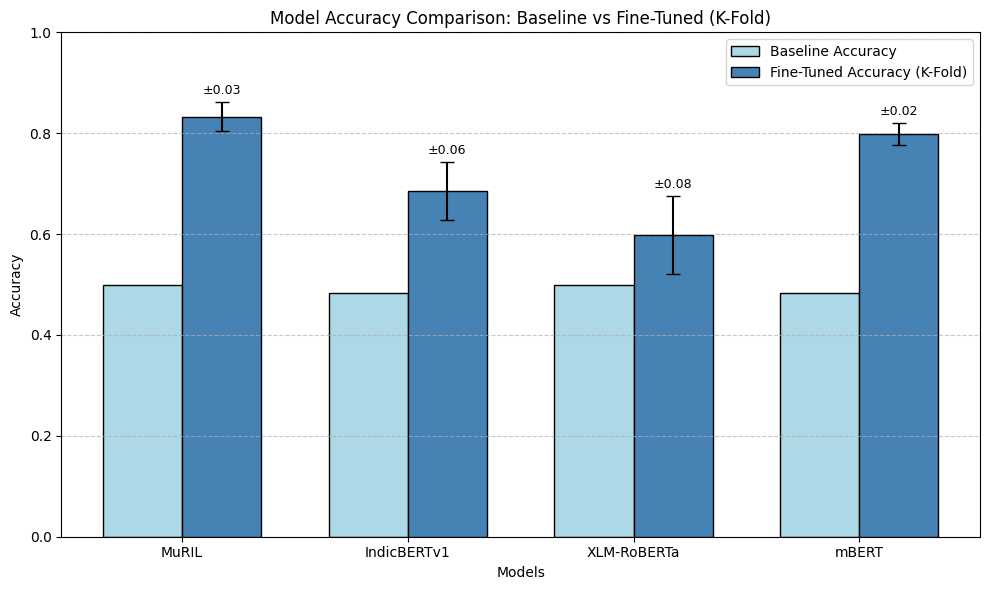

In [17]:
import matplotlib.pyplot as plt

# Extract model names
models = list(baseline_results.keys())

# Extract baseline and k-fold means/stds
baseline_acc = [baseline_results[m] for m in models]
kfold_acc = [kfold_results[m]["mean"] for m in models]
kfold_std = [kfold_results[m]["std"] for m in models]

x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))

# Baseline accuracy bars
plt.bar(
    [i - bar_width / 2 for i in x],
    baseline_acc,
    bar_width,
    label='Baseline Accuracy',
    color='lightblue',
    edgecolor='black'
)

# K-Fold accuracy bars with std error bars
bars = plt.bar(
    [i + bar_width / 2 for i in x],
    kfold_acc,
    bar_width,
    yerr=kfold_std,
    capsize=5,
    label='Fine-Tuned Accuracy (K-Fold)',
    color='steelblue',
    edgecolor='black'
)

# Add std deviation labels above K-Fold bars
for i, (acc, std) in enumerate(zip(kfold_acc, kfold_std)):
    plt.text(
        i + bar_width / 2,
        acc + std + 0.01,
        f"±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Plot styling
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Baseline vs Fine-Tuned (K-Fold)')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#11.**Model Testing: Intra-sentential vs Inter-sentential vs Tag-Switch (Testing Separately)**



=== Model Accuracy Report ===

--- MuRIL ---
Intra-sentential    : 0.8000
Inter-sentential    : 0.7500
Tag-Switch          : 0.9375
Average Accuracy    : 0.8292

--- IndicBERTv1 ---
Intra-sentential    : 0.6000
Inter-sentential    : 0.7000
Tag-Switch          : 0.6875
Average Accuracy    : 0.6625

--- XLM-RoBERTa ---
Intra-sentential    : 0.5000
Inter-sentential    : 0.5500
Tag-Switch          : 0.5000
Average Accuracy    : 0.5167

--- mBERT ---
Intra-sentential    : 0.7000
Inter-sentential    : 0.7000
Tag-Switch          : 0.8125
Average Accuracy    : 0.7375



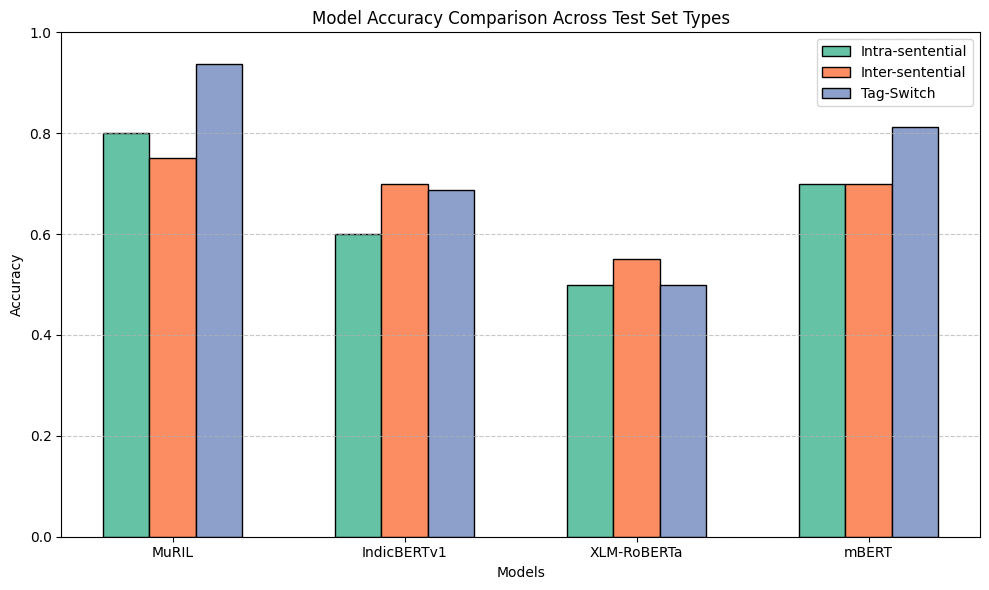

In [19]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
intra_df = pd.read_csv("Intra_sentential.csv", header=None, names=["text", "sentiment"])
inter_df = pd.read_csv("Inter-sentential.csv", header=None, names=["text", "sentiment"])
tag_df = pd.read_csv("Tag_Switch.csv", header=None, names=["text", "sentiment"])

test_sets = {
    "Intra-sentential": intra_df,
    "Inter-sentential": inter_df,
    "Tag-Switch": tag_df
}

# Label mapping
label_map = {"Positive": 1, "Negative": 0}

# Pretrained model folders
MODELS = {
    "MuRIL": "google_muril-base-cased_model_final",
    "IndicBERTv1": "ai4bharat_indic-bert_model_final",
    "XLM-RoBERTa": "xlm-roberta-base_model_final",
    "mBERT": "bert-base-multilingual-cased_model_final"
}

# Store accuracy by model and test set
accuracy_by_model = {model: [] for model in MODELS.keys()}

# Evaluation function
def evaluate_saved_model(model_name, model_path, df, device):
    df = df.dropna(subset=["text", "sentiment"])
    df["cleaned_text"] = df["text"].apply(preprocess_text)
    df["devanagari_text"] = df["cleaned_text"].apply(transliterate_roman_to_devanagari)
    df["processed_devanagari"] = df["devanagari_text"].apply(preprocess_devanagari_text)
    df["labels"] = df["sentiment"].map(label_map)
    df = df.dropna(subset=["labels"])

    X_test = df["processed_devanagari"]
    y_test = df["labels"]

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    test_dataset = SentimentDataset(X_test, y_test, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=8)

    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    total, correct = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Run evaluation and print results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n=== Model Accuracy Report ===\n")
for model_name, model_path in MODELS.items():
    print(f"--- {model_name} ---")
    for set_name in ["Intra-sentential", "Inter-sentential", "Tag-Switch"]:
        df = test_sets[set_name].copy()
        accuracy = evaluate_saved_model(model_name, model_path, df, device)
        accuracy_by_model[model_name].append(accuracy)
        print(f"{set_name:<20}: {accuracy:.4f}")

    # Compute and print average accuracy
    avg_accuracy = sum(accuracy_by_model[model_name]) / len(accuracy_by_model[model_name])
    print(f"{'Average Accuracy':<20}: {avg_accuracy:.4f}\n")

# Prepare data for plotting
models = list(accuracy_by_model.keys())
intra_acc = [accuracy_by_model[m][0] for m in models]
inter_acc = [accuracy_by_model[m][1] for m in models]
tag_acc   = [accuracy_by_model[m][2] for m in models]

x = np.arange(len(models))
bar_width = 0.2

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, intra_acc, width=bar_width, label='Intra-sentential',
        color='#66c2a5', edgecolor='black')
plt.bar(x, inter_acc, width=bar_width, label='Inter-sentential',
        color='#fc8d62', edgecolor='black')
plt.bar(x + bar_width, tag_acc, width=bar_width, label='Tag-Switch',
        color='#8da0cb', edgecolor='black')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison Across Test Set Types")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 12. **Cross-Script Evaluation: Train on Roman, Test on Devanagari**

In [20]:
# --- Cross-Script Evaluation: Train on Roman, Test on Devanagari (Fresh Models + No Data Leakage) ---

print("\n--- Train on Roman Script, Test on Devanagari Script ---")

# Step 1: Reload dataset and preprocess Roman
df = pd.read_csv("Dataset.csv")
df.columns = ["text", "sentiment"]
df["cleaned_text"] = df["text"].apply(preprocess_text)

# Encode labels
label_map = {"Positive": 1, "Negative": 0}
df["labels"] = df["sentiment"].map(label_map)

# Step 2: Split dataset BEFORE transliteration to avoid leakage
from sklearn.model_selection import train_test_split

X_train_rom, X_test_rom, y_train, y_test = train_test_split(
    df["cleaned_text"], df["labels"], test_size=0.2, random_state=42, stratify=df["labels"]
)

# Step 3: Transliterate ONLY the test data to Devanagari
X_test_dev = X_test_rom.apply(transliterate_roman_to_devanagari).reset_index(drop=True)
X_train_rom = X_train_rom.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Step 4: Define fresh model names from Hugging Face
MODELS = {
    "MuRIL": "google/muril-base-cased",
    "IndicBERTv1": "ai4bharat/indic-bert",
    "XLM-RoBERTa": "xlm-roberta-base",
    "mBERT": "bert-base-multilingual-cased",
}

cross_script_results = {}

for model_name, model_path in MODELS.items():
    print(f"\n--- Training on Roman | Testing on Devanagari — {model_name} ---")

    if model_name not in best_hyperparameters:
        print(f"Skipping {model_name}: No best hyperparameters found.")
        continue

    # Load best hyperparameters
    params = best_hyperparameters[model_name]
    epochs = params["epochs"]
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]
    freeze_layers = params.get("freeze_layers", False)
    freeze_embeddings = params.get("freeze_embeddings", False)

    # Print hyperparameters used
    print("Best Hyperparameters:")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Freeze Layers: {freeze_layers}")
    print(f"  Freeze Embeddings: {freeze_embeddings}")

    # Load fresh tokenizer and model from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Freeze layers if required
    if freeze_embeddings:
        if hasattr(model, 'bert'):
            for param in model.bert.embeddings.parameters():
                param.requires_grad = False
        elif hasattr(model, 'roberta'):
            for param in model.roberta.embeddings.parameters():
                param.requires_grad = False
        elif hasattr(model, 'xlm_roberta'):
            for param in model.xlm_roberta.embeddings.parameters():
                param.requires_grad = False

    if freeze_layers:
        if hasattr(model, 'bert'):
            for param in model.bert.encoder.parameters():
                param.requires_grad = False
        elif hasattr(model, 'roberta'):
            for param in model.roberta.encoder.parameters():
                param.requires_grad = False
        elif hasattr(model, 'xlm_roberta'):
            for param in model.xlm_roberta.encoder.parameters():
                param.requires_grad = False

    model.to(device)

    # Prepare datasets and loaders
    train_dataset = SentimentDataset(X_train_rom, y_train, tokenizer)
    test_dataset = SentimentDataset(X_test_dev, y_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * epochs)

    # Training loop
    print(f"\n[Training {model_name}]")
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_acc:.4f}")

    # Evaluation loop
    print(f"\n[Testing {model_name} on Devanagari]")
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    cross_script_results[model_name] = acc

    print(f"\n{model_name} Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

# Step 6: Summary
print("\n--- Cross-Script Accuracy Summary (Roman → Devanagari) ---")
for model, acc in cross_script_results.items():
    print(f"{model}: {acc:.4f}")



--- Train on Roman Script, Test on Devanagari Script ---

--- Training on Roman | Testing on Devanagari — MuRIL ---
Best Hyperparameters:
  Epochs: 9
  Batch Size: 16
  Learning Rate: 1.824073538598386e-05
  Freeze Layers: False
  Freeze Embeddings: False


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training MuRIL]
Epoch 1/9 - Loss: 0.6933 - Accuracy: 0.5021
Epoch 2/9 - Loss: 0.6928 - Accuracy: 0.5021
Epoch 3/9 - Loss: 0.6904 - Accuracy: 0.5021
Epoch 4/9 - Loss: 0.6813 - Accuracy: 0.5146
Epoch 5/9 - Loss: 0.6608 - Accuracy: 0.7992
Epoch 6/9 - Loss: 0.6388 - Accuracy: 0.9414
Epoch 7/9 - Loss: 0.6175 - Accuracy: 0.9540
Epoch 8/9 - Loss: 0.5995 - Accuracy: 0.9874
Epoch 9/9 - Loss: 0.5947 - Accuracy: 0.9749

[Testing MuRIL on Devanagari]

MuRIL Test Accuracy: 0.7833
Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79        30
    Positive       0.79      0.77      0.78        30

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60


--- Training on Roman | Testing on Devanagari — IndicBERTv1 ---
Best Hyperparameters:
  Epochs: 12
  Batch Size: 4
  Learning Rate: 1.9426831872606918e-05
  Freeze Layers: Fal

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training IndicBERTv1]
Epoch 1/12 - Loss: 0.6943 - Accuracy: 0.4644
Epoch 2/12 - Loss: 0.6892 - Accuracy: 0.5397
Epoch 3/12 - Loss: 0.6219 - Accuracy: 0.6987
Epoch 4/12 - Loss: 0.6515 - Accuracy: 0.6569
Epoch 5/12 - Loss: 0.5159 - Accuracy: 0.7950
Epoch 6/12 - Loss: 0.3467 - Accuracy: 0.8745
Epoch 7/12 - Loss: 0.2551 - Accuracy: 0.9205
Epoch 8/12 - Loss: 0.2014 - Accuracy: 0.9498
Epoch 9/12 - Loss: 0.1276 - Accuracy: 0.9707
Epoch 10/12 - Loss: 0.0957 - Accuracy: 0.9749
Epoch 11/12 - Loss: 0.0811 - Accuracy: 0.9749
Epoch 12/12 - Loss: 0.0707 - Accuracy: 0.9749

[Testing IndicBERTv1 on Devanagari]

IndicBERTv1 Test Accuracy: 0.5500
Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      1.00      0.69        30
    Positive       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60


--- Traini

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training XLM-RoBERTa]
Epoch 1/6 - Loss: 0.7030 - Accuracy: 0.4854
Epoch 2/6 - Loss: 0.7076 - Accuracy: 0.5105
Epoch 3/6 - Loss: 0.7018 - Accuracy: 0.5188
Epoch 4/6 - Loss: 0.6875 - Accuracy: 0.5690
Epoch 5/6 - Loss: 0.6898 - Accuracy: 0.5146
Epoch 6/6 - Loss: 0.6929 - Accuracy: 0.5188

[Testing XLM-RoBERTa on Devanagari]

XLM-RoBERTa Test Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        30
    Positive       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60


--- Training on Roman | Testing on Devanagari — mBERT ---
Best Hyperparameters:
  Epochs: 14
  Batch Size: 16
  Learning Rate: 3.602419798422996e-05
  Freeze Layers: False
  Freeze Embeddings: True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training mBERT]
Epoch 1/14 - Loss: 0.7121 - Accuracy: 0.4812
Epoch 2/14 - Loss: 0.6858 - Accuracy: 0.5941
Epoch 3/14 - Loss: 0.7156 - Accuracy: 0.4937
Epoch 4/14 - Loss: 0.6619 - Accuracy: 0.6067
Epoch 5/14 - Loss: 0.4777 - Accuracy: 0.7950
Epoch 6/14 - Loss: 0.3038 - Accuracy: 0.8828
Epoch 7/14 - Loss: 0.1943 - Accuracy: 0.9414
Epoch 8/14 - Loss: 0.1072 - Accuracy: 0.9623
Epoch 9/14 - Loss: 0.0612 - Accuracy: 0.9791
Epoch 10/14 - Loss: 0.1201 - Accuracy: 0.9665
Epoch 11/14 - Loss: 0.0500 - Accuracy: 0.9916
Epoch 12/14 - Loss: 0.0043 - Accuracy: 1.0000
Epoch 13/14 - Loss: 0.0075 - Accuracy: 0.9958
Epoch 14/14 - Loss: 0.0022 - Accuracy: 1.0000

[Testing mBERT on Devanagari]

mBERT Test Accuracy: 0.6167
Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.47      0.55        30
    Positive       0.59      0.77      0.67        30

    accuracy                           0.62        60
   macro avg       0.63      0.62      0.61   

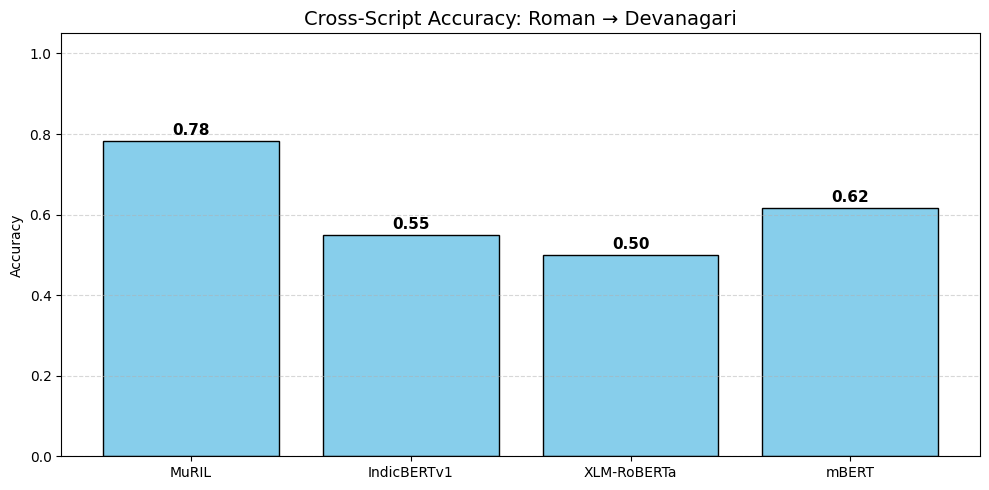

In [21]:
# --- Plot Histogram of Cross-Script Accuracies (Without Error Bars, Custom Color) ---

import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(cross_script_results.keys())
accuracies = [cross_script_results[model] for model in model_names]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, accuracies, color='skyblue', edgecolor='black')

# Add accuracy labels on top of each bar
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f"{acc:.2f}", ha='center', fontsize=11, weight='bold')

# Formatting
plt.title("Cross-Script Accuracy: Roman → Devanagari", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 13. **Cross-Script Evaluation: Train on Devnagri, Test on Roman**

In [23]:

# Step 1: Reload dataset and preprocess Roman
df = pd.read_csv("Dataset.csv")
df.columns = ["text", "sentiment"]
df["cleaned_text"] = df["text"].apply(preprocess_text)

# Encode labels
label_map = {"Positive": 1, "Negative": 0}
df["labels"] = df["sentiment"].map(label_map)

# Step 2: Split dataset BEFORE transliteration to avoid leakage
from sklearn.model_selection import train_test_split

X_train_rom, X_test_rom, y_train, y_test = train_test_split(
    df["cleaned_text"], df["labels"], test_size=0.2, random_state=42, stratify=df["labels"]
)

# Step 3: Transliterate ONLY the train data to Devanagari
X_test_rom = X_test_rom.reset_index(drop=True)
X_train_dev = X_train_rom.apply(transliterate_roman_to_devanagari).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Step 4: Define model names from Hugging Face
MODELS = {
    "MuRIL": "google/muril-base-cased",
    "IndicBERTv1": "ai4bharat/indic-bert",
    "XLM-RoBERTa": "xlm-roberta-base",
    "mBERT": "bert-base-multilingual-cased",
}

cross_script_results = {}

for model_name, model_path in MODELS.items():
    print(f"\n--- Training on Devanagari | Testing on Roman — {model_name} ---")

    if model_name not in best_hyperparameters:
        print(f"Skipping {model_name}: No best hyperparameters found.")
        continue

    # Load best hyperparameters
    params = best_hyperparameters[model_name]
    epochs = params["epochs"]
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]
    freeze_layers = params.get("freeze_layers", False)
    freeze_embeddings = params.get("freeze_embeddings", False)

    # Print hyperparameters used
    print("Best Hyperparameters:")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Freeze Layers: {freeze_layers}")
    print(f"  Freeze Embeddings: {freeze_embeddings}")

    # Load fresh tokenizer and model from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Freeze layers if required
    if freeze_embeddings:
        if hasattr(model, 'bert'):
            for param in model.bert.embeddings.parameters():
                param.requires_grad = False
        elif hasattr(model, 'roberta'):
            for param in model.roberta.embeddings.parameters():
                param.requires_grad = False
        elif hasattr(model, 'xlm_roberta'):
            for param in model.xlm_roberta.embeddings.parameters():
                param.requires_grad = False

    if freeze_layers:
        if hasattr(model, 'bert'):
            for param in model.bert.encoder.parameters():
                param.requires_grad = False
        elif hasattr(model, 'roberta'):
            for param in model.roberta.encoder.parameters():
                param.requires_grad = False
        elif hasattr(model, 'xlm_roberta'):
            for param in model.xlm_roberta.encoder.parameters():
                param.requires_grad = False

    model.to(device)

    # Prepare datasets and loaders
    train_dataset = SentimentDataset(X_train_dev, y_train, tokenizer)
    test_dataset = SentimentDataset(X_test_rom, y_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * epochs)

    # Training loop
    print(f"\n[Training {model_name}]")
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_acc:.4f}")

    # Evaluation loop
    print(f"\n[Testing {model_name} on Devanagari]")
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    cross_script_results[model_name] = acc

    print(f"\n{model_name} Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

# Step 6: Summary
print("\n--- Cross-Script Accuracy Summary (Devanagari → Roman ) ---")
for model, acc in cross_script_results.items():
    print(f"{model}: {acc:.4f}")



--- Training on Devanagari | Testing on Roman — MuRIL ---
Best Hyperparameters:
  Epochs: 9
  Batch Size: 16
  Learning Rate: 1.824073538598386e-05
  Freeze Layers: False
  Freeze Embeddings: False


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training MuRIL]
Epoch 1/9 - Loss: 0.6933 - Accuracy: 0.4561
Epoch 2/9 - Loss: 0.6927 - Accuracy: 0.6192
Epoch 3/9 - Loss: 0.6907 - Accuracy: 0.6360
Epoch 4/9 - Loss: 0.6822 - Accuracy: 0.7699
Epoch 5/9 - Loss: 0.6718 - Accuracy: 0.7699
Epoch 6/9 - Loss: 0.6519 - Accuracy: 0.8954
Epoch 7/9 - Loss: 0.6364 - Accuracy: 0.9331
Epoch 8/9 - Loss: 0.6284 - Accuracy: 0.9289
Epoch 9/9 - Loss: 0.6178 - Accuracy: 0.9623

[Testing MuRIL on Devanagari]

MuRIL Test Accuracy: 0.6667
Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.97      0.74        30
    Positive       0.92      0.37      0.52        30

    accuracy                           0.67        60
   macro avg       0.76      0.67      0.63        60
weighted avg       0.76      0.67      0.63        60


--- Training on Devanagari | Testing on Roman — IndicBERTv1 ---
Best Hyperparameters:
  Epochs: 12
  Batch Size: 4
  Learning Rate: 1.9426831872606918e-05
  Freeze Layers: Fal

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training IndicBERTv1]
Epoch 1/12 - Loss: 0.6938 - Accuracy: 0.4812
Epoch 2/12 - Loss: 0.6932 - Accuracy: 0.5105
Epoch 3/12 - Loss: 0.6795 - Accuracy: 0.6402
Epoch 4/12 - Loss: 0.5770 - Accuracy: 0.7573
Epoch 5/12 - Loss: 0.3611 - Accuracy: 0.8703
Epoch 6/12 - Loss: 0.1321 - Accuracy: 0.9665
Epoch 7/12 - Loss: 0.0766 - Accuracy: 0.9833
Epoch 8/12 - Loss: 0.0164 - Accuracy: 0.9958
Epoch 9/12 - Loss: 0.0020 - Accuracy: 1.0000
Epoch 10/12 - Loss: 0.0016 - Accuracy: 1.0000
Epoch 11/12 - Loss: 0.0014 - Accuracy: 1.0000
Epoch 12/12 - Loss: 0.0014 - Accuracy: 1.0000

[Testing IndicBERTv1 on Devanagari]

IndicBERTv1 Test Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        30
    Positive       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60


--- Traini

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training XLM-RoBERTa]
Epoch 1/6 - Loss: 0.7223 - Accuracy: 0.4728
Epoch 2/6 - Loss: 0.6903 - Accuracy: 0.5314
Epoch 3/6 - Loss: 0.7000 - Accuracy: 0.5439
Epoch 4/6 - Loss: 0.7160 - Accuracy: 0.4728
Epoch 5/6 - Loss: 0.6878 - Accuracy: 0.5774
Epoch 6/6 - Loss: 0.6954 - Accuracy: 0.4937

[Testing XLM-RoBERTa on Devanagari]

XLM-RoBERTa Test Accuracy: 0.4833
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        30
    Positive       0.49      0.97      0.65        30

    accuracy                           0.48        60
   macro avg       0.25      0.48      0.33        60
weighted avg       0.25      0.48      0.33        60


--- Training on Devanagari | Testing on Roman — mBERT ---
Best Hyperparameters:
  Epochs: 14
  Batch Size: 16
  Learning Rate: 3.602419798422996e-05
  Freeze Layers: False
  Freeze Embeddings: True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[Training mBERT]
Epoch 1/14 - Loss: 0.7114 - Accuracy: 0.4770
Epoch 2/14 - Loss: 0.7058 - Accuracy: 0.4895
Epoch 3/14 - Loss: 0.6891 - Accuracy: 0.5230
Epoch 4/14 - Loss: 0.5632 - Accuracy: 0.6946
Epoch 5/14 - Loss: 0.3990 - Accuracy: 0.8326
Epoch 6/14 - Loss: 0.1965 - Accuracy: 0.9205
Epoch 7/14 - Loss: 0.0871 - Accuracy: 0.9749
Epoch 8/14 - Loss: 0.1055 - Accuracy: 0.9749
Epoch 9/14 - Loss: 0.0310 - Accuracy: 0.9916
Epoch 10/14 - Loss: 0.0182 - Accuracy: 0.9958
Epoch 11/14 - Loss: 0.0069 - Accuracy: 0.9958
Epoch 12/14 - Loss: 0.0076 - Accuracy: 0.9958
Epoch 13/14 - Loss: 0.0019 - Accuracy: 1.0000
Epoch 14/14 - Loss: 0.0018 - Accuracy: 1.0000

[Testing mBERT on Devanagari]

mBERT Test Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

    Negative       0.52      0.93      0.67        30
    Positive       0.67      0.13      0.22        30

    accuracy                           0.53        60
   macro avg       0.59      0.53      0.44   

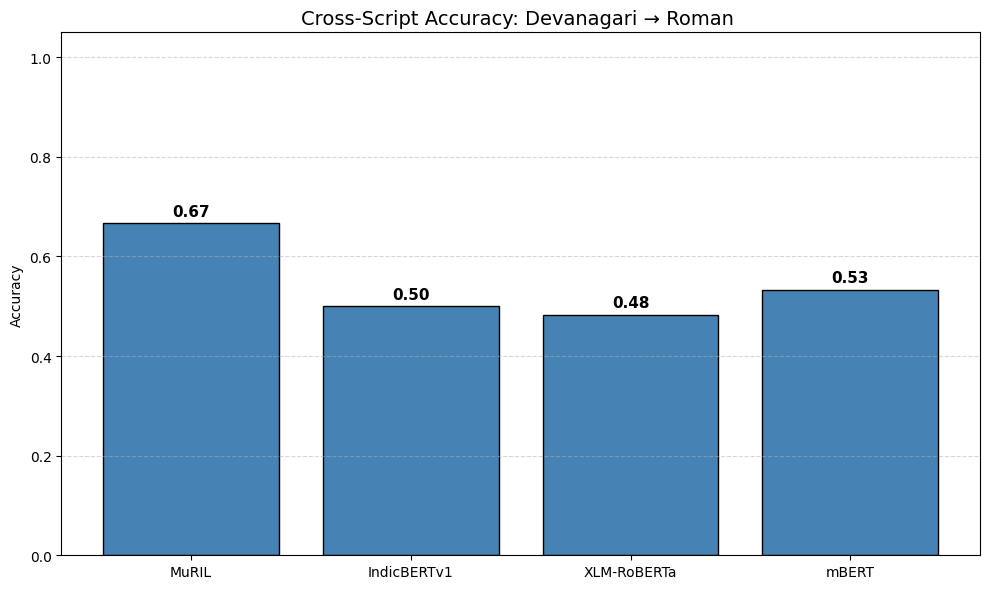

In [24]:
# --- Plot Histogram for Devanagari → Roman  (Train: Roman, Test: Devanagari) Accuracy ---

import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(cross_script_results.keys())
accuracies = [cross_script_results[model] for model in model_names]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='steelblue', edgecolor='black')

# Add accuracy labels on top of each bar
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f"{acc:.2f}", ha='center', fontsize=11, weight='bold')

# Formatting
plt.title("Cross-Script Accuracy: Devanagari → Roman ", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
